Importing Libraries

In [1]:
import os
import optuna
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Set the path to the directories containing your training and testing datasets
train_dir = 'E:\Python\MobileNet-V2-Batik-Image-Classification\dataset-v3[600]-5\data-train'
test_dir = 'E:\Python\MobileNet-V2-Batik-Image-Classification\dataset-v3[600]-5\data-test'

In [3]:
# Set the number of classes in your dataset
num_classes = 5

# Set the input shape for MobileNetV2
input_shape = (224, 224, 3)

# Set the number of trials for hyperparameter tuning
num_trials = 5

Preprocessing and Augmentation

In [4]:
# Create an image data generator with data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.4,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  brightness_range=[0.8, 1.2],
                                  validation_split=0.2)

#note: test data should not have to be augmented
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [5]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape[:2],
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

Found 435 images belonging to 5 classes.


In [6]:
eval_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=input_shape[:2],
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=True)

Found 105 images belonging to 5 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape[:2],
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 60 images belonging to 5 classes.


Hyperparameters Tuning

In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune and their search spaces
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Build the MobileNetV2 model
    base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate, decay=weight_decay),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    # Train the model
    model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=eval_generator,
          validation_steps=len(eval_generator),
          epochs=25,
          batch_size=batch_size,
          verbose=1)

    # Evaluate the model on the evaluation generator
    _, accuracy = model.evaluate(eval_generator, steps=len(eval_generator), verbose=0)

    return accuracy

In [9]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=num_trials)

[I 2023-07-16 00:19:08,098] A new study created in memory with name: no-name-bfdccb6d-0b16-4e68-84a5-3389bacbb608
C:\Users\Zia\AppData\Local\Temp\ipykernel_7724\2460344492.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Zia\AppData\Local\Temp\ipykernel_7724\2460344492.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)


Epoch 1/25
14/14 [==============================] - 42s 3s/step - loss: 2.7688 - accuracy: 0.5034 - val_loss: 0.6555 - val_accuracy: 0.7810
Epoch 2/25
14/14 [==============================] - 32s 2s/step - loss: 0.4836 - accuracy: 0.8000 - val_loss: 0.3417 - val_accuracy: 0.8762
Epoch 3/25
14/14 [==============================] - 32s 2s/step - loss: 0.3988 - accuracy: 0.8598 - val_loss: 0.3931 - val_accuracy: 0.8667
Epoch 4/25
14/14 [==============================] - 31s 2s/step - loss: 0.3101 - accuracy: 0.8966 - val_loss: 0.3125 - val_accuracy: 0.8857
Epoch 5/25
14/14 [==============================] - 31s 2s/step - loss: 0.1881 - accuracy: 0.9448 - val_loss: 0.2938 - val_accuracy: 0.8857
Epoch 6/25
14/14 [==============================] - 34s 2s/step - loss: 0.1467 - accuracy: 0.9517 - val_loss: 0.2340 - val_accuracy: 0.9333
Epoch 7/25
14/14 [==============================] - 35s 3s/step - loss: 0.1510 - accuracy: 0.9494 - val_loss: 0.1874 - val_accuracy: 0.9238
Epoch 8/25
14/14 [==

[I 2023-07-16 00:32:54,185] Trial 0 finished with value: 0.9142857193946838 and parameters: {'learning_rate': 0.004727242931492625, 'batch_size': 32, 'weight_decay': 1.1969071273930583e-05}. Best is trial 0 with value: 0.9142857193946838.


Epoch 1/25
14/14 [==============================] - 36s 2s/step - loss: 1.0594 - accuracy: 0.5954 - val_loss: 0.4923 - val_accuracy: 0.8286
Epoch 2/25
14/14 [==============================] - 31s 2s/step - loss: 0.4589 - accuracy: 0.8414 - val_loss: 0.3573 - val_accuracy: 0.8762
Epoch 3/25
14/14 [==============================] - 32s 2s/step - loss: 0.3720 - accuracy: 0.8552 - val_loss: 0.2779 - val_accuracy: 0.8952
Epoch 4/25
14/14 [==============================] - 32s 2s/step - loss: 0.2951 - accuracy: 0.8736 - val_loss: 0.1720 - val_accuracy: 0.9429
Epoch 5/25
14/14 [==============================] - 33s 2s/step - loss: 0.2626 - accuracy: 0.8989 - val_loss: 0.2320 - val_accuracy: 0.9048
Epoch 6/25
14/14 [==============================] - 31s 2s/step - loss: 0.1979 - accuracy: 0.9356 - val_loss: 0.2605 - val_accuracy: 0.9238
Epoch 7/25
14/14 [==============================] - 33s 2s/step - loss: 0.1721 - accuracy: 0.9563 - val_loss: 0.2309 - val_accuracy: 0.9333
Epoch 8/25
14/14 [==

[I 2023-07-16 00:48:02,096] Trial 1 finished with value: 0.9523809552192688 and parameters: {'learning_rate': 0.0004765747724614533, 'batch_size': 16, 'weight_decay': 1.0687890682057259e-05}. Best is trial 1 with value: 0.9523809552192688.


Epoch 1/25
14/14 [==============================] - 45s 3s/step - loss: 1.5794 - accuracy: 0.2943 - val_loss: 1.4317 - val_accuracy: 0.3810
Epoch 2/25
14/14 [==============================] - 33s 2s/step - loss: 1.4034 - accuracy: 0.4368 - val_loss: 1.3107 - val_accuracy: 0.4857
Epoch 3/25
14/14 [==============================] - 28s 2s/step - loss: 1.2826 - accuracy: 0.5195 - val_loss: 1.0539 - val_accuracy: 0.6381
Epoch 4/25
14/14 [==============================] - 29s 2s/step - loss: 1.1729 - accuracy: 0.5816 - val_loss: 0.9965 - val_accuracy: 0.7143
Epoch 5/25
14/14 [==============================] - 29s 2s/step - loss: 1.0300 - accuracy: 0.6667 - val_loss: 0.9340 - val_accuracy: 0.7524
Epoch 6/25
14/14 [==============================] - 28s 2s/step - loss: 0.9651 - accuracy: 0.6966 - val_loss: 0.8457 - val_accuracy: 0.7714
Epoch 7/25
14/14 [==============================] - 30s 2s/step - loss: 0.8862 - accuracy: 0.7287 - val_loss: 0.7811 - val_accuracy: 0.7905
Epoch 8/25
14/14 [==

[I 2023-07-16 01:02:13,404] Trial 2 finished with value: 0.8952381014823914 and parameters: {'learning_rate': 2.2958737783902388e-05, 'batch_size': 16, 'weight_decay': 3.3174839033887735e-06}. Best is trial 1 with value: 0.9523809552192688.


Epoch 1/25
14/14 [==============================] - 37s 2s/step - loss: 1.8058 - accuracy: 0.2437 - val_loss: 1.4945 - val_accuracy: 0.3524
Epoch 2/25
14/14 [==============================] - 35s 3s/step - loss: 1.4819 - accuracy: 0.3586 - val_loss: 1.3811 - val_accuracy: 0.4667
Epoch 3/25
14/14 [==============================] - 34s 2s/step - loss: 1.3484 - accuracy: 0.4529 - val_loss: 1.2128 - val_accuracy: 0.5619
Epoch 4/25
14/14 [==============================] - 37s 3s/step - loss: 1.2353 - accuracy: 0.5103 - val_loss: 1.0614 - val_accuracy: 0.6762
Epoch 5/25
14/14 [==============================] - 34s 2s/step - loss: 1.0841 - accuracy: 0.6230 - val_loss: 0.9520 - val_accuracy: 0.6667
Epoch 6/25
14/14 [==============================] - 34s 2s/step - loss: 1.0128 - accuracy: 0.6920 - val_loss: 0.8862 - val_accuracy: 0.7810
Epoch 7/25
14/14 [==============================] - 37s 3s/step - loss: 0.9185 - accuracy: 0.7126 - val_loss: 0.8053 - val_accuracy: 0.7714
Epoch 8/25
14/14 [==

[I 2023-07-16 01:17:00,376] Trial 3 finished with value: 0.9047619104385376 and parameters: {'learning_rate': 2.315660848137008e-05, 'batch_size': 64, 'weight_decay': 1.6047070525320193e-05}. Best is trial 1 with value: 0.9523809552192688.


Epoch 1/25
14/14 [==============================] - 39s 3s/step - loss: 1.1721 - accuracy: 0.5379 - val_loss: 0.5395 - val_accuracy: 0.8286
Epoch 2/25
14/14 [==============================] - 30s 2s/step - loss: 0.5064 - accuracy: 0.8345 - val_loss: 0.3735 - val_accuracy: 0.8857
Epoch 3/25
14/14 [==============================] - 29s 2s/step - loss: 0.3679 - accuracy: 0.8828 - val_loss: 0.2954 - val_accuracy: 0.9238
Epoch 4/25
14/14 [==============================] - 29s 2s/step - loss: 0.3008 - accuracy: 0.9103 - val_loss: 0.2253 - val_accuracy: 0.9333
Epoch 5/25
14/14 [==============================] - 32s 2s/step - loss: 0.2378 - accuracy: 0.9218 - val_loss: 0.2105 - val_accuracy: 0.9429
Epoch 6/25
14/14 [==============================] - 32s 2s/step - loss: 0.2117 - accuracy: 0.9310 - val_loss: 0.2384 - val_accuracy: 0.8857
Epoch 7/25
14/14 [==============================] - 31s 2s/step - loss: 0.1768 - accuracy: 0.9540 - val_loss: 0.1751 - val_accuracy: 0.9619
Epoch 8/25
14/14 [==

[I 2023-07-16 01:30:18,674] Trial 4 finished with value: 0.9238095283508301 and parameters: {'learning_rate': 0.00030975220004941984, 'batch_size': 64, 'weight_decay': 7.626594035377629e-06}. Best is trial 1 with value: 0.9523809552192688.


In [10]:
# Get the best hyperparameters from the study
best_params = study.best_params
best_val_accuracy = study.best_value

In [11]:
# Rebuild the model with the best hyperparameters
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_weight_decay = best_params['weight_decay']
# best_dropout_rate = best_params['dropout_rate']

print(f"best_learning_rate : {best_learning_rate} ")
print(f"best_batch_size : {best_batch_size} ")
print(f"best_weight_decay : {best_weight_decay} ")
print(f"best_val_accuracy : {best_val_accuracy*100:.2f}%")

best_learning_rate : 0.0004765747724614533 
best_batch_size : 16 
best_weight_decay : 1.0687890682057259e-05 
best_val_accuracy : 95.24%


Create Model from Best Parameters

In [13]:
# Create MobileNetV2 base for best model
base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final best model
best_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the best model
best_model.compile(optimizer=Adam(learning_rate=best_learning_rate,
                                  decay=best_weight_decay),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [15]:
# Train the model with the best hyperparameters
best_model.fit(train_generator,
               epochs=5,
               batch_size=best_batch_size,
               validation_data=eval_generator)

Epoch 1/5
14/14 [==============================] - 32s 2s/step - loss: 1.0639 - accuracy: 0.5632 - val_loss: 0.5336 - val_accuracy: 0.7810
Epoch 2/5
14/14 [==============================] - 29s 2s/step - loss: 0.4808 - accuracy: 0.8345 - val_loss: 0.3195 - val_accuracy: 0.8857
Epoch 3/5
14/14 [==============================] - 28s 2s/step - loss: 0.2976 - accuracy: 0.9034 - val_loss: 0.2992 - val_accuracy: 0.8952
Epoch 4/5
14/14 [==============================] - 28s 2s/step - loss: 0.2644 - accuracy: 0.9172 - val_loss: 0.1969 - val_accuracy: 0.9429
Epoch 5/5
14/14 [==============================] - 29s 2s/step - loss: 0.2215 - accuracy: 0.9356 - val_loss: 0.1562 - val_accuracy: 0.9714


In [16]:
# Evaluate the model on the training set
train_loss, train_accuracy = best_model.evaluate(train_generator)
print(f"Training accuracy: {train_accuracy*100:.2f}%")

14/14 [==============================] - 30s 2s/step - loss: 0.1810 - accuracy: 0.9471
Training accuracy: 94.71%


Evaluate The Model

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

2/2 [==============================] - 3s 1s/step - loss: 0.1886 - accuracy: 0.9167
Test accuracy: 91.67%


Confusion Matrix and Classification Report

In [18]:
# Perform predictions on the test set
test_predictions = best_model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
# test_pred_labels = [1 * (x[0]>=0.5) for x in test_predictions]
# Get the true labels for the test set
test_true_labels = test_generator.classes

2/2 [==============================] - 4s 1s/step


Confusion Matrix:
[[10  1  0  1  0]
 [ 0 11  1  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 12  0]
 [ 0  0  2  0 10]]


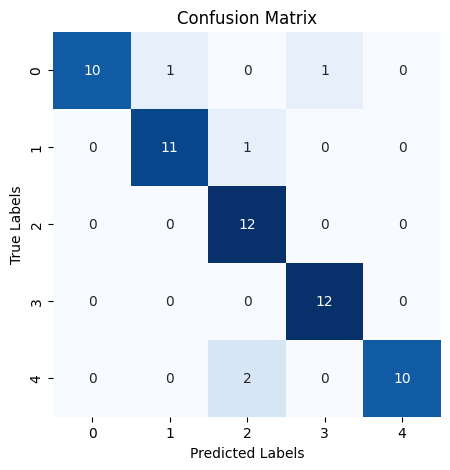

In [19]:
# Calculate and print confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Calculate and print classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.92      0.92      0.92        12
           2       0.80      1.00      0.89        12
           3       0.92      1.00      0.96        12
           4       1.00      0.83      0.91        12

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



Prediction Test

In [55]:
# Path to the image you want to test
image_path = 'E:\Python\MobileNet-V2-Batik-Image-Classification\dataset-v1[600]-10\data-test/8/6.jpg'

In [56]:
# Load the image
img = Image.open(image_path)
img = img.resize(input_shape[:2])
img_array = np.array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [57]:
# Make predictions
predictions = best_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels = list(test_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

1/1 [==============================] - 0s 93ms/step


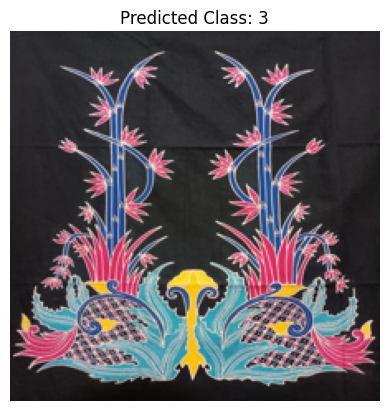

In [58]:
# Display the image
plt.imshow(img)
plt.axis('off')
plt.title('Predicted Class: ' + predicted_label)
plt.show()